## Catalog cross-matching

Some conventions I use:
- The first letter of `astropy.table` object variable names are capitalized
- First letters of `pandas.DataFrame` names are lowercase
- CXO, CSC = Chandra X-ray Observatory, Chandra Source Catalog
- XMM, SSC = XMM-Newton, Serendipitous Source Catalog
- XRT, XPS = (Swift) X-ray Telescope, XRT Point Source (catalog)
- BeSS = Be Star Spectra database

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, astropy.units as u, pickle, seaborn as sns, sympy
from mpl_toolkits import mplot3d
from scipy import stats, optimize
from PyAstronomy import pyasl
from astropy.io import fits, ascii as ascii_io, votable
from astropy.coordinates import SkyCoord, Angle
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from uncertainties import AsymmetricUncertainty

from tools import hms_to_dec, dms_to_dec

keV = 2.418e17 # Hz

## Pseudo-manually matched

In [2]:
Be_xray_cat = pd.read_csv("BeStarXrayCatalog.csv")
Be_xray_cat.columns

Index(['BeSS #', 'Name', 'RA', 'Dec', 'Vmag', 'SpecType',
       'Simbad classification', 'Catalog memberships',
       'Literature classification', 'Reference', 'epsi', 'sepsi', 'BP-RP',
       'Parallax', 'Parallax_err', 'Gflux', 'Gflux_corrected', 'Gflux_err',
       'Gmag', 'Gmag_corrected', 'Gmag_err', 'PM', 'PM_dec', 'pmdec_error',
       'PM_RA', 'PM_RA_err', 'rgeo', 'rpgeo', 'Fluxb', 'Fluxh', 'Fluxm',
       'Fluxs', 'Fluxu', 'Fluxw', 'HRhm', 'HRhs', 'HRms', 'NHGal', 'S_N',
       '2CXO', '2SXPS', 'CR0', 'E_CR0', 'e_CR0', 'SwiftHR1', 'SwiftHR2', 'CR1',
       'e_CR1', 'CR2', 'E_CR2', 'e_CR2', 'CR3', 'E_CR3', 'e_CR3', 'PcstS0',
       'FPO0', 'FPU0', 'Gam1', 'E_Gam1', 'e_Gam1', '4XMM', 'Flux1', 'e_Flux1',
       'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5',
       'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1', 'e_HR1',
       'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4', '2MASS', 'Jmag', 'Hmag',
       'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'WI

## Old method below

### Initialize ViZier query instance

In [3]:
v = Vizier(columns=['all', '_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

### Load the [Be star database](http://basebe.obspm.fr/basebe/)

In [4]:
BeSS = ascii_io.read("./catalogs/BeSS_catalog.csv", format="csv", header_start=0, data_start=1)
BeSS["_RAJ2000"] = [hms_to_dec(hms) for hms in BeSS["RA"]]*u.degree
BeSS["_DEJ2000"] = [dms_to_dec(dms) for dms in BeSS["DEC"]]*u.degree
BeSS.pprint()

 #    Be star    Category ...       _RAJ2000            _DEJ2000     
                          ...         deg                 deg        
---- ---------- --------- ... ------------------- -------------------
   1 BD+62 2346 Classical ... 0.35291666666666666   63.50436944444444
   2  HD 224905 Classical ...  0.4109583333333333   60.44992222222222
   3  HD 225095 Classical ...            0.863125  55.550897222222225
   4      2 Cet Classical ...  0.9349583333333333 -17.335991666666665
   5     10 Cas Classical ...  1.6105833333333333   64.19616944444445
   6 BD+59 2829 Classical ...             1.70125  60.600230555555555
   7    BD+62 1 Classical ...  1.8881250000000003  63.080327777777775
   8   BD+62 11 Classical ...              2.6955   63.17293611111111
   9   V742 Cas Classical ...  2.9047916666666667   58.21182777777778
  10   EM* AS 2 Classical ...            3.246875   66.32206388888889
 ...        ...       ... ...                 ...                 ...
2255   V817 Cas Clas

### Crossmatch with Gaia data

Create `gaia_df`, a `pandas.DataFrame` containing the single closest match (within $1^{\prime\prime}$) in the Gaia catalog for every entry in the BeSS database.

In [5]:
Gaia_BeSS_1as = v.query_region(BeSS, catalog="I/350/gaiaedr3", radius="1s")
Gaia_matched = Gaia_BeSS_1as[0]["_q","_r","Source","Plx","pmRA","pmDE","epsi","sepsi","Gmag","BPmag","RPmag","Tefftemp"]

gaia_df = Gaia_matched.to_pandas()
for i in BeSS["#"]:
    instances = len(gaia_df[gaia_df["_q"]==i])
    if instances == 0:
        pass
    elif instances >= 2:
        dupeframe = gaia_df[gaia_df["_q"]==i][["_q","_r"]]
        gaia_df.drop(dupeframe[dupeframe["_r"]>min(dupeframe["_r"])].index, inplace=True)

gaia_df.dropna(axis=0, subset=["_r"], inplace=True)
F0 = 2.9979246e-5 * 3631 / (6217.59**2) # Jy -> erg/cm^2/s/Ang
gaia_df["Gflux"] = F0 * 10**(gaia_df["Gmag"]/-2.5)

assert(len(gaia_df) == len(np.unique(gaia_df["_q"]))),"Something went wrong..."

In [6]:
gaia_dists = v.query_region(BeSS, catalog="I/352/gedr3dis",radius="1s")[0].to_pandas()
gaia = pd.merge(gaia_df, gaia_dists, on="Source", how="left")
gaia.drop(['_r_x', 'Source', '_q_y', '_RAJ2000', '_DEJ2000', '_r_y', 'RA_ICRS', 'DE_ICRS', 'Flag'], axis=1, inplace=True)
gaia.rename(columns={"_q_x":"_q"}, inplace=True)

### HMXB crossmatch

- 2CXO J210335.6+454505 with 92%/100% is a HMXB in our TD
- 2CXO J213930.6+565910 with 83%/99% is a HMXB from Simbad, but not in our TD
- 2CXO J112057.1-615500 with 96%/100% is a HMXB from Liu+06 in our TD
- 2CXO J223920.8+611626 with 81%/100% is a HMXB from Liu+06 in our TD
- 2CXO J174445.7-271344 #  not significant with 45%/70% is a HMXB in our TD, but a Be Star in Simbad
- 2CXO J024031.6+611345 #  not significant with 58%/95% is a HMXB from Liu+06
- 2CXO J113106.9-625648 #  not significant with 36%/35% is not in our TD, is a HMXB from Simbad
- 2CXO J130247.6-635008 #  not significant with 53%/56% is not in our TD, is a HMXB from Simbad, 
- 2CXO J134632.5-625523 #  not significant with 44%/47% is not in our TD, is a Be Star from Simbad

In [7]:
HMXBs_BeSS_1as = v.query_region(BeSS, catalog="J/A+A/455/1165/table1", radius="1s")

### XMM, Chandra, and Swift/XRT catalogs

| Band      | Energy bin range |
|-----------|------------------|
| XMM Flux1 | 0.2 - 0.5 keV    |
| XMM Flux2 | 0.5 - 1.0 keV    |
| XMM Flux3 | 1.0 - 2.0 keV    |
| XMM Flux4 | 2.0 - 4.5 keV    |
| XMM Flux5 | 4.5 - 12.0 keV   |
| XMM Flux8 | 0.2 - 12.0 keV   |
| XMM Flux9 | 0.5 - 4.5 keV    |
| CXO Fluxu | 0.2 - 0.5 keV    |
| CXO Fluxs | 0.5 - 1.2 keV    |
| CXO Fluxm | 1.2 - 2.0 keV    |
| CXO Fluxh | 2.0 - 7.0 keV    |
| CXO Fluxb | 0.5 - 7.0 keV    |
| XRT Soft  | 0.3 - 1.0 keV    |
| XRT Med   | 1.0 - 2.0 keV    |
| XRT Hard  | 2.0 - 10.0 keV   |

Load the full catalogs from locally stored copies. Crossmatch from vizier remotely.

In [7]:
cat_ids = ["IX/59/xmm4dr9s","IX/57/csc2master","IX/58/2sxpscle"]
Xmatch = [None, None, None]
radii = ["2s","1s","5s"]
for i in range(len(cat_ids)):
    Xmatch[i] = v.query_region(BeSS, catalog=cat_ids[i], radius=radii[i])
    print("Successfully matched BeSS with",cat_ids[i])
[XMM_xmatch, CSC_xmatch, XRT_xmatch] = Xmatch

Successfully matched BeSS with IX/59/xmm4dr9s
Successfully matched BeSS with IX/57/csc2master
Successfully matched BeSS with IX/58/2sxpscle


In [8]:
Chandra_sources = CSC_xmatch[0]["_q","_2CXO",'Fluxb', 'Fluxh', 'Fluxm',
       'Fluxs', 'Fluxu', 'Fluxw', 'HRhm', 'HRhs', 'HRms', 'GamPL', 'NHPL']
chandra_bands = {"b":(0.5,7), "h":(2,7), "m":(1.2,2), "s":(0.5,1.2), "u":(0.2,0.5)}

XMM_sources = XMM_xmatch[0]["_q","_4XMM",'Flux1', 'e_Flux1',
       'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5',
       'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1', 'e_HR1',
       'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4']
xmm_bands = dict(zip(list("1234589"),[(0.2,0.5),(0.5,1.0),(1.0,2.0),(2.0,4.5),(4.5,12.0),(0.2,12.0),(0.5,4.5)]))

XRT_sources = XRT_xmatch[0]["_q",'_2SXPS', 'CR0', 'E_CR0', 'e_CR0', 'HR1', 'HR2', 'CR1',
       'e_CR1', 'CR2', 'E_CR2', 'e_CR2', 'CR3', 'E_CR3', 'e_CR3', 'PcstS0',
       'FPO0', 'FPU0', 'Gam1', 'E_Gam1', 'e_Gam1']

### WISE and 2MASS

In [9]:
twomass_xmatch = v.query_region(BeSS, catalog="II/246/out", radius="0.5s")
catwise_xmatch = v.query_region(BeSS, catalog="II/365/catwise", radius="0.5s")
allwise_xmatch = v.query_region(BeSS, catalog="II/328/allwise", radius="0.5s")
unwise_xmatch = v.query_region(BeSS, catalog="II/363/unwise", radius="0.5s")

In [10]:
twomass = twomass_xmatch[0].to_pandas()
catwise = catwise_xmatch[0].to_pandas()
allwise = allwise_xmatch[0].to_pandas()
unwise = unwise_xmatch[0].to_pandas()

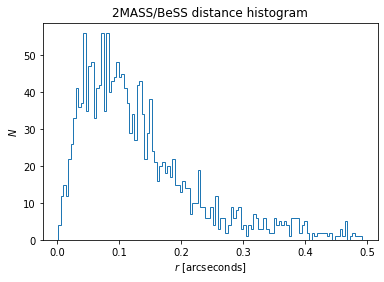

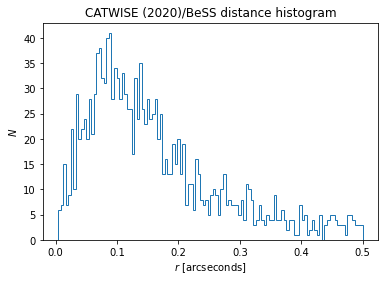

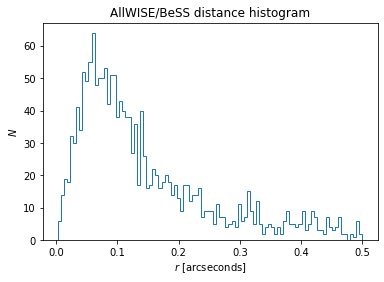

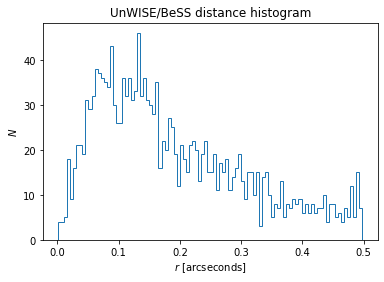

In [12]:
plt.hist(twomass["_r"],bins=120,histtype="step")
#plt.vlines(1,0,100,color="k",linestyle="--")
#plt.xlim(-1,2)
plt.xlabel("$r$ [arcseconds]")
plt.ylabel("$N$")
plt.title("2MASS/BeSS distance histogram")
plt.show()

plt.hist(catwise["_r"],bins=120,histtype="step")
#plt.vlines(1,0,1750,color="k",linestyle="--")
#plt.xlim(-1,40)
plt.xlabel("$r$ [arcseconds]")
plt.ylabel("$N$")
plt.title("CATWISE (2020)/BeSS distance histogram")
plt.show()

plt.hist(allwise["_r"],bins=100,histtype="step")
#plt.vlines(1,0,1650,color="k",linestyle="--")
#plt.xlim(0,1)
plt.xlabel("$r$ [arcseconds]")
plt.ylabel("$N$")
plt.title("AllWISE/BeSS distance histogram")
plt.show()

plt.hist(unwise["_r"],bins=100,histtype="step")
#plt.vlines(1,0,1650,color="k",linestyle="--")
#plt.xlim(-1,40)
plt.xlabel("$r$ [arcseconds]")
plt.ylabel("$N$")
plt.title("UnWISE/BeSS distance histogram")
plt.show()

#### Filter WISE stuff

In [11]:
wise = pd.DataFrame(columns=["_q","W1","e_W1","W2","e_W2","W3","e_W3","W4","e_W4"])
for q in BeSS["#"]:
    
    W1 = W2 = W3 = W4 = np.nan
    e_W1 = e_W2 = e_W3 = e_W4 = np.nan
    
    if (catwise["_q"] == q).any():
        W1 = catwise.loc[catwise["_q"]==q, "W1mproPM"].values[0]
        e_W1 = catwise.loc[catwise["_q"]==q, "e_W1mproPM"].values[0]
        W2 = catwise.loc[catwise["_q"]==q, "W2mproPM"].values[0]
        e_W2 = catwise.loc[catwise["_q"]==q, "e_W2mproPM"].values[0]
        
    elif (unwise["_q"] == q).any():
        fw1 = unwise.loc[unwise["_q"]==q, "FW1"].values[0]
        e_fw1 = unwise.loc[unwise["_q"]==q, "e_FW1"].values[0]
        FW1 = AsymmetricUncertainty(fw1,e_fw1,e_fw1)
        fw2 = unwise.loc[unwise["_q"]==q, "FW2"].values[0]
        e_fw2 = unwise.loc[unwise["_q"]==q, "e_FW2"].values[0]
        FW2 = AsymmetricUncertainty(fw2,e_fw2,e_fw2)
        w1 = 22.5 - 2.5*np.log10(FW1) - 0.004
        w2 = 22.5 - 2.5*np.log10(FW2) - 0.032
        W1 = w1.value
        e_W1 = w1.plus
        W2 = w2.value
        e_W2 = w2.plus
    
    if (allwise["_q"] == q).any():
        if pd.isna(W1):
            W1 = allwise.loc[allwise["_q"]==q, "W1mag"].values[0]
            e_W1 = allwise.loc[allwise["_q"]==q, "e_W1mag"].values[0]
        if pd.isna(W2):
            W2 = allwise.loc[allwise["_q"]==q, "W2mag"].values[0]
            e_W2 = allwise.loc[allwise["_q"]==q, "e_W2mag"].values[0]
        W3 = allwise.loc[allwise["_q"]==q, "W3mag"].values[0]
        e_W3 = allwise.loc[allwise["_q"]==q, "e_W3mag"].values[0]
        W4 = allwise.loc[allwise["_q"]==q, "W4mag"].values[0]
        e_W4 = allwise.loc[allwise["_q"]==q, "e_W4mag"].values[0]
        
    wise = wise.append(dict(zip(wise.columns, [q,W1,e_W1,W2,e_W2,W3,e_W3,W4,e_W4])), ignore_index=True)

C:\Users\Caden Gobat\Documents\GitHub\Be-star-binaries\uncertainties.py:201: RuntimeWarning: divide by zero encountered in log10
  result = np.log10(self.value)
C:\Users\Caden Gobat\Documents\GitHub\Be-star-binaries\uncertainties.py:202: RuntimeWarning: invalid value encountered in double_scalars
  pos = self.plus/(self.value*np.log(10))
C:\Users\Caden Gobat\Documents\GitHub\Be-star-binaries\uncertainties.py:203: RuntimeWarning: invalid value encountered in double_scalars
  neg = self.minus/(self.value*np.log(10))
C:\Users\Caden Gobat\Documents\GitHub\Be-star-binaries\uncertainties.py:43: RuntimeWarning: invalid value encountered in double_scalars
  self.sign = self.value/np.abs(self.value) if self.value != 0 else 1
<ipython-input-11-9b6de50a5faf>:20: RuntimeWarning: invalid value encountered in log10
  w1 = 22.5 - 2.5*np.log10(FW1) - 0.004
C:\Users\Caden Gobat\Documents\GitHub\Be-star-binaries\uncertainties.py:201: RuntimeWarning: divide by zero encountered in log10
  result = np.log1

### Compile a master catalog

In [57]:
objs = pd.merge(wise, twomass_xmatch[0][['_q',"Jmag","e_Jmag","Hmag","e_Hmag","Kmag","e_Kmag"]].to_pandas(), on="_q", how="outer")
objs = pd.merge(gaia, objs, on="_q", how="outer")
xray = pd.merge(XMM_sources.to_pandas(), Chandra_sources.to_pandas(), on="_q", how="outer")
xray = pd.merge(xray, XRT_sources.to_pandas(), on="_q", how="outer")

master = pd.merge(BeSS.to_pandas(), pd.merge(objs, xray, on="_q", how="outer"), left_on="#", right_on="_q", how="outer")
master.rename(columns={"HR1_x":"HR1","HR2_x":"HR2","HR1_y":"SwiftHR1","HR2_y":"SwiftHR2"},inplace=True)

### Solve for individual-band Swift fluxes

In [58]:
for i in master[master["_2SXPS"].notna()].index:
    # knowns
    SwiftHR1 = master.loc[i,"SwiftHR1"]
    SwiftHR2 = master.loc[i,"SwiftHR2"]
    SwiftFlux = master.loc[i,"FPO0"]

    # unknowns
    F0,F1,F2 = sympy.symbols("F_s, F_m, F_h")
    
    # equations
    fluxsum = sympy.Eq(F0+F1+F2, SwiftFlux)
    hr1 = sympy.Eq((F1-F0)/(F1+F0), SwiftHR1)
    hr2 = sympy.Eq((F2-F1)/(F2+F1), SwiftHR2)
    
    # solution
    solution = sympy.solve((fluxsum,hr1,hr2), (F0,F1,F2))
    master.loc[i,"XRTsoft"] = float(solution[F0])
    master.loc[i,"XRTmed"] = float(solution[F1])
    master.loc[i,"XRThard"] = float(solution[F2])

In [30]:
def infer_gamma(HR,freq1a,freq1b,freq2a,freq2b):
    #G = sympy.var("Gamma")
    #hr_eq = sympy.Eq(((freq2b**(2-G) - freq2a**(2-G)) - (freq1b**(2-G) - freq1a**(2-G)))/((freq2b**(2-G) - freq2a**(2-G)) + (freq1b**(2-G) - freq1a**(2-G))), HR)
    hr_func = lambda G : -HR + ((freq2b**(2-G) - freq2a**(2-G)) - (freq1b**(2-G) - freq1a**(2-G)))/((freq2b**(2-G) - freq2a**(2-G)) + (freq1b**(2-G) - freq1a**(2-G)))
    solution = optimize.fsolve(hr_func, 1) #sympy.solve(hr_eq, G)
    return solution

### Simple conversion assuming $\Gamma=2$

In [14]:
CSC_fluxs = ['Fluxh', 'Fluxm', 'Fluxs']
XMM_fluxs = ['Flux1', 'Flux2', 'Flux3', 'Flux4', 'Flux5']
XRT_fluxs = ['XRTsoft', 'XRTmed', 'XRThard']

In [36]:
chandra_coefs = [(np.log10(1)-np.log10(0.3))/(np.log10(1.2)-np.log10(0.5)),
                 (np.log10(2)-np.log10(1))/(np.log10(2)-np.log10(1.2)),
                 (np.log10(10)-np.log10(2))/(np.log10(7)-np.log10(2))]
newton_coefs = [[(np.log10(1)-np.log10(0.3))/(np.log10(1)-np.log10(0.5)),
                 1,
                 (np.log10(10)-np.log10(2))/(np.log10(12)-np.log10(2))]]
for i in master[master["_2CXO"].notna() | master["_4XMM"].notna() | master["_2SXPS"].notna()].index:
    cxoflux, xmmflux, xrtflux = master.loc[i,CSC_fluxs].values, master.loc[i,XMM_fluxs].values, master.loc[i,XRT_fluxs].values
    #print(cxoflux,xmmflux,xrtflux)
    cxo = cxoflux*chandra_coefs
    xmm = (np.array([xmmflux[0],xmmflux[1],xmmflux[2]+xmmflux[3]])*newton_coefs).flatten()
    result = {"0.3-1.0":[cxo[0],xmm[0],xrtflux[0]],
              "1.0-2.0":[cxo[1],xmm[1],xrtflux[1]],
              "2.0-10.":[cxo[2],xmm[2],xrtflux[2]]}
    if i in candidates.index:
        if pd.notna(xmm[0]):
            candidates.loc[i,"XRTsoft"] = xmm[0]
        if pd.notna(xmm[1]):
            candidates.loc[i,"XRTmed"] = xmm[1]
        if pd.notna(xmm[2]):
            candidates.loc[i,"XRThard"] = xmm[2]

### Comprehensive conversions

In [59]:
for i in master[master["_2CXO"].notna() | master["_4XMM"].notna() | master["_2SXPS"].notna()].index:
    cxoflux, xmmflux, xrtflux = master.loc[i,CSC_fluxs].values, master.loc[i,XMM_fluxs].values, master.loc[i,XRT_fluxs].values
    if pd.notna(master.loc[i,"GamPL"]): # spectral index from Chandra
        Gamma = float(master.loc[i,"GamPL"])
    elif pd.notna(master.loc[i,"Gam1"]): # spectral index from Swift
        Gamma = float(master.loc[i,"Gam1"])
    else: # assume flat spectrum for general case
        Gamma = 2
    if all(pd.notna(cxoflux)): # good Chandra observations present
        if Gamma != 2:
            coefs = np.array([(1**(2.-Gamma)-0.3**(2.-Gamma))/(1.2**(2.-Gamma)-0.5**(2.-Gamma)),
                          (2**(2.-Gamma)-1**(2.-Gamma))/(2.**(2.-Gamma)-1.2**(2.-Gamma)),
                          (10**(2.-Gamma)-2**(2.-Gamma))/(7**(2.-Gamma)-2**(2.-Gamma))])
        else:
            coefs = np.array([(np.log(1)-np.log(0.3))/(np.log(1.2)-np.log(0.5)),
                              (np.log(2)-np.log(1))/(np.log(2.0)-np.log(1.2)),
                              (np.log(10)-np.log(2))/(np.log(7)-np.log(2))])
        converted = cxoflux * coefs
        source = "CXO"
    elif all(pd.notna(xmmflux)): # no Chandra, but good XMM
        mergedxmm = np.array([xmmflux[0]+xmmflux[1], xmmflux[2], xmmflux[3]+xmmflux[4]])
        if Gamma != 2:
            coefs = np.array([(1**(2.-Gamma)-0.3**(2.-Gamma))/(1**(2.-Gamma)-0.2**(2.-Gamma)),
                          1, (10**(2.-Gamma)-2**(2.-Gamma))/(12**(2.-Gamma)-2**(2.-Gamma))])
        else:
            coefs = np.array([(np.log(1)-np.log(0.3))/(np.log(1)-np.log(0.2)),
                              1, (np.log(10)-np.log(2))/(np.log(12)-np.log(2))])
        converted = mergedxmm * coefs
        source = "XMM"
    elif all(pd.notna(xrtflux)): # neither Chandra nor XMM, but good Swift-XRT
        converted = xrtflux
        source = "XRT"
    else:
        continue
    
    master.loc[i,"Flux (0.3-1 keV)"] = converted[0]
    master.loc[i,"Flux (1-2 keV)"] = converted[1]
    master.loc[i,"Flux (2-10 keV)"] = converted[2]
    master.loc[i,"X-ray source"] = source

In [ ]:
for i in master.index:
    flags = []
    if pd.notna(master.loc[i,"Be star"]):
        flags.append("BeSS")
    if pd.notna(master.loc[i,"EDR3Name"]):
        flags.append("Gaia")
#     if pd.notna(master.loc[i,"Name"]):
#         flags.append("HMXB")
    if pd.notna(master.loc[i,"_4XMM"]):
        flags.append("XMM")
    if pd.notna(master.loc[i,"_2CXO"]):
        flags.append("Chandra")
    master.loc[i,"Memberships"] = ",".join(flags)

Text(0.5, 1.0, 'Color-magnitude diagram of Gaia-matched Be stars')

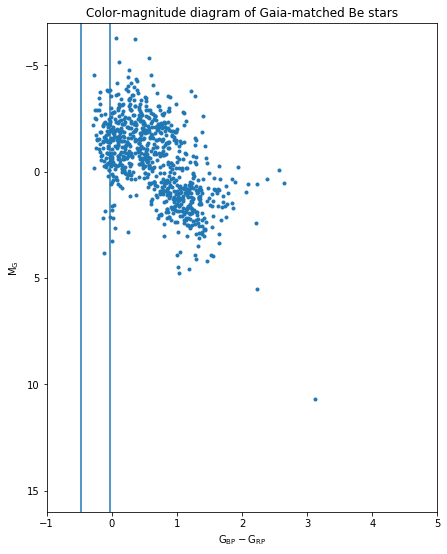

In [74]:
plt.figure(figsize=(7,9))
plt.scatter(master["BPmag"]-master["RPmag"], master["Gmag"]-5*np.log10(master["rpgeo"]/10),marker=".")
plt.ylim(16,-7)
plt.xlim(-1,5)
plt.vlines([-0.4769230769230768,-0.03076923076923066],-10,20) # WebPlotDigitized bounds of B type from Gaia HR diagram
plt.xlabel("$\mathrm{G}_\mathrm{BP}-\mathrm{G}_\mathrm{RP}$")
plt.ylabel("$\mathrm{M}_\mathrm{G}$")
plt.title("Color-magnitude diagram of Gaia-matched Be stars")

In [ ]:
master.columns

In [ ]:
#master.to_csv("./catalogs/BeSS+Gaia+HMXBs+CSC+XMM+XRT.csv", index=False)